In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
# set plotting style
plt.rcParams.update({'errorbar.capsize': 3})
sns.set(style="ticks", rc={"figure.figsize":(5.51, 4.13)})  # for 1.5 column figures 
sns.set_context(context="paper")
dpi = 1000

## Define functions

In [2]:
def plot_indices(df, scen_name):
    # first order sensitivity
    ax = plot_s1(df, scen_name)
    plt.tight_layout()
    plt.savefig("output\\sensi_sobol_S1_" + scen_name + ".png", dpi=dpi)
    plt.show()
    # total effect sensitivity
    ax = plot_st(df, scen_name)
    plt.tight_layout()
    plt.savefig("output\\sensi_sobol_ST_" + scen_name + ".png", dpi=dpi)
    

def plot_s1(df, scen_name):
    """ plot first order sensitivity index """
    ax = sns.barplot(y=df.loc["S1", :], x=df.columns, yerr=df.loc["S1_conf", :], capsize=10)
    plt.ylim(bottom=0)
    rename_categories(plt.xticks)
    return ax
    
def plot_st(df, scen_name):
    """ plot total sensitivity index """  
    ax = sns.barplot(y=df.loc["ST", :], x=df.columns, yerr=df.loc["ST_conf", :])
    plt.ylim(bottom=0)
    rename_categories(plt.xticks)
    return ax
    
def read_pickle(scen_name):
    df = pd.read_pickle("data//pickle//" + scen_name + "_indices.pkl")
    df_samples = pd.read_pickle("data//pickle//" + scen_name + "_samples.pkl")
    # unit conversion
    df_samples["alpha"] = df_samples["alpha"] / 1000                      # in kW/m²/K
    df_samples["N_s"] = df_samples["N_s"] * 10**9                         # in 1/m²
    df_samples["p_steam"] = df_samples["p_steam"] / 10                    # mbar to kPa    
    if "delta_coat" in df_samples.columns:
        df_samples["delta_coat"] = df_samples["delta_coat"] * 10**6       # in my m
    return df, df_samples

def rename_categories(xticks):
    locs, labels = xticks()
    for label in labels:
        old_text = label.get_text()
        if old_text == "Theta":
            new_text = r"$\theta$"
        elif old_text == "alpha":
            new_text = r"$\alpha$"
        elif old_text == "CAH":
            new_text = r"$\Delta \theta$"
        elif old_text == "p_steam":
            new_text = r"$p$" 
        elif old_text == "N_s":
            new_text = r"$N_{\rm{s}}$"
        elif old_text == "delta_coat":
            new_text = r"$\delta_{\rm{c}}$"
        elif old_text == "k_coat":
            new_text = r"$\lambda_{\rm{c}}$" 
        else:
            new_text = old_text    
        label.set_text(new_text)
    plt.xticks(locs, labels)

def get_new_label_text(old_text):
    if old_text == "Theta":
        new_text = r"$\theta \ \rm{/} \ \rm{deg}$"
    elif old_text == "alpha":
        new_text = r"$\alpha^{*} \ \rm{/} \ \rm{(kW/m^2/K)}$"
    elif old_text == "CAH":
        new_text = r"$\Delta \theta \ \rm{/} \ \rm{deg}$"
    elif old_text == "p_steam":
        new_text = r"$p \ \rm{/} \ \rm{kPa}$" 
    elif old_text == "N_s":
        new_text = r"$N_{\rm{s}} \ \rm{/} \ \rm{m^{-2}}$"
    elif old_text == "delta_coat":
        new_text = r"$\delta_{\rm{c}} \ \rm{/} \ \rm{\mu m}$"
    elif old_text == "k_coat":
        new_text = r"$\lambda_{\rm{c}} \ \rm{/} \ \rm{(W/m/K)}$" 
    else:
        new_text = old_text
    return new_text

def rename_labels(ax):
    ax = plt.gca()
    for label in [ax.xaxis.get_label(), ax.yaxis.get_label(), ax.get_legend().get_texts()[0]]:
        old_text = label.get_text()
        new_text = get_new_label_text(old_text)
        label.set_text(new_text)        
        
def filter_samples(df_samples):
    #filter for cah and ca
    print("original samples: \t\t", df_samples.shape[0])
    df_samples = df_samples[(df_samples["Theta"] > (0.5*df_samples["CAH"])) & ((0.5*df_samples["CAH"] + df_samples["Theta"]) < 180)]
    print("samples after CAH filter: \t", df_samples.shape[0])
    # bond <= critical Bond number?
    df_samples["bo < bo_crit"] = df_samples["bond"] <= Bo_crit
    print("samples with bo > bo_crit: \t", df_samples[df_samples["bo < bo_crit"] == False].shape[0])
    print("minimum Bond number: \t\t", round(df_samples["bond"].min(), 3))
    print("maximum Bond number: \t\t", round(df_samples["bond"].max(), 3))
    return (df_samples)

Bo_crit = 1.4     # define critcal Bond number for filmwise to dropwise condensation transition

# Create figures

## Total effects indices

### Figure 1 - comparison of total effects indices

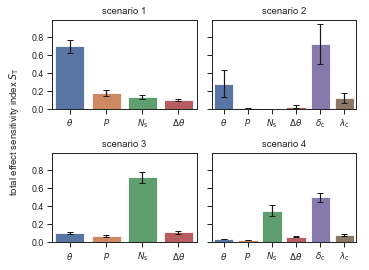

In [3]:
df_list = []
scen_names = ["s1", "s2", "s3", "s4"]
for scen in scen_names:
    df, _ = read_pickle(scen)
    df_list.append(df)

cols_nocoat = ['Theta', 'p_steam', 'N_s', "CAH"]
cols_coat = cols_nocoat + ['delta_coat', 'k_coat']    
    
fig, axs = plt.subplots(2, 2, sharey=True)
row = 0
col = 0
for df in df_list:
    if col == 0:
        df = df[cols_nocoat]
    else:
        df = df[cols_coat]
    sns.barplot(y=df.loc["ST", :], x=df.columns, yerr=df.loc["ST_conf", :], ax=axs[row, col])
    col += 1
    if col > 1:
        row = 1
        col = 0 

for row in axs:
    for ax in row:
        plt.sca(ax)
        ax.yaxis.get_label().set_visible(False)
        plt.ylim(bottom=0)
        rename_categories(plt.xticks)
        
axs[0, 0].title.set_text("scenario 1")
axs[0, 1].title.set_text("scenario 2")
axs[1, 0].title.set_text("scenario 3")
axs[1, 1].title.set_text("scenario 4")

# common title for y-axis
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("total effect sensitivity index " + r"$S_{\rm{T}}$", labelpad=10)

plt.tight_layout()
plt.savefig("output\\sensi_fig1_sobol_ST_overview.pdf", dpi=dpi)
plt.savefig("output\\sensi_fig1_sobol_ST_overview.jpg", dpi=dpi)

## Scenario 1
* large input parameter space based on physical plausibility
* no coating

In [4]:
scen_name = "s1"
df, df_samples = read_pickle(scen_name)

# prepare and filter results
df_samples = filter_samples(df_samples)
print("\nsensitivity:")
print(df)

original samples: 		 10000
samples after CAH filter: 	 7899
samples with bo > bo_crit: 	 2312
minimum Bond number: 		 0.0
maximum Bond number: 		 43.855

sensitivity:
            Theta   p_steam       N_s       CAH
S1       0.605458  0.129317  0.084517  0.081245
S1_conf  0.063841  0.032022  0.031573  0.032837
ST       0.696475  0.177399  0.128058  0.099169
ST_conf  0.067038  0.028548  0.022166  0.014042


C:\Users\Sablowski\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Figure 2 - contact angle and pressure

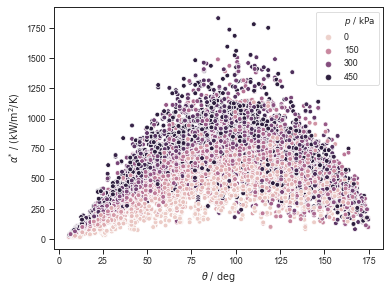

In [5]:
ax = sns.scatterplot(data=df_samples, y="alpha", x=df.columns[0], hue=df.columns[1], hue_norm=(0, 450))
rename_labels(ax)
plt.tight_layout()
xlim = plt.xlim()
ylim = plt.ylim()
plt.savefig("output\\sensi_fig2_sobol_scatter_1_" + scen_name + ".pdf", dpi=dpi)
plt.savefig("output\\sensi_fig2_sobol_scatter_1_" + scen_name + ".jpg", dpi=dpi)

Contact angles at which the highest heat transfer rates occur

In [6]:
df_temp = df_samples[df_samples["alpha"] > 1300]
print(df_temp.Theta.min())
print(df_temp.Theta.max())
print(df_temp.Theta.mean())

70.6591796875
131.9189453125
101.5380859375


### Figure 3 - contact angle and contact angle hysteresis, only datapoints with Bo < Bo_crit

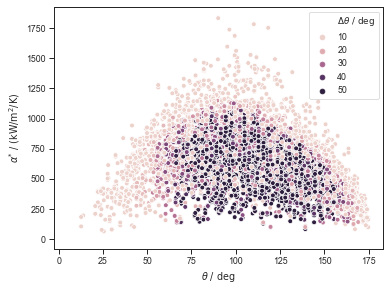

In [7]:
ax = sns.scatterplot(data=df_samples[df_samples["bo < bo_crit"] == True], y="alpha", x=df.columns[0], hue="CAH", hue_norm=(15, 45))
rename_labels(ax)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.savefig("output\\sensi_fig3_sobol_scatter_1_" + scen_name + "_bondfiltered_CAH.pdf", dpi=dpi)
plt.savefig("output\\sensi_fig3_sobol_scatter_1_" + scen_name + "_bondfiltered_CAH.jpg", dpi=dpi)

maximum contact angle hystereses for high heat transfer coefficients:

In [8]:
df_temp = df_samples[df_samples["bo < bo_crit"] == True]
df_temp = df_temp[df_temp["alpha"] > 1300]
print(df_temp.CAH.max())

8.86572265625


maximum contact angle hystereses for DWC on very hydrophilic surfaces:

In [9]:
df_temp = df_samples[df_samples["bo < bo_crit"] == True]
df_temp = df_temp[df_temp["Theta"] < 60]
print(df_temp.CAH.max())

32.50634765625


## Scenario 2
* large input parameter space based on physical plausibility
* consider coating

In [10]:
scen_name = "s2"
df, df_samples = read_pickle(scen_name)

# prepare and filter results
df_samples = filter_samples(df_samples)
print("\nsensitivity:")
print(df)

original samples: 		 14000
samples after CAH filter: 	 11026
samples with bo > bo_crit: 	 3251
minimum Bond number: 		 0.0
maximum Bond number: 		 45.467

sensitivity:
         delta_coat     Theta    k_coat       CAH       N_s   p_steam
S1         0.510346  0.118435  0.059818  0.002592  0.000602 -0.002997
S1_conf    0.259676  0.059126  0.032743  0.017128  0.002777  0.003284
ST         0.722464  0.280946  0.120753  0.026106  0.001783  0.006343
ST_conf    0.222702  0.151874  0.054575  0.012010  0.000982  0.006573


C:\Users\Sablowski\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Figure 4 - coating thickness and contact angle

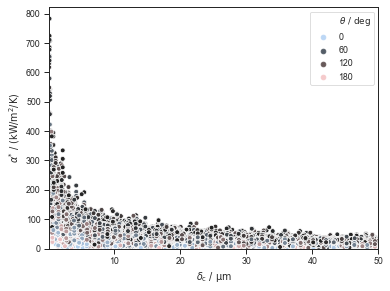

In [11]:
ax = sns.scatterplot(data=df_samples, y="alpha", x=df.columns[0], hue=df.columns[1], 
                     palette=sns.diverging_palette(240, 10, l=85, as_cmap=True, center="dark"))
plt.xlim(0.1, 50)
plt.ylim(bottom=0)
#plt.xscale("log")
rename_labels(ax)
plt.tight_layout()
plt.savefig("output\\sensi_fig4_sobol_scatter_1_" + scen_name + ".pdf", dpi=dpi)
plt.savefig("output\\sensi_fig4_sobol_scatter_1_" + scen_name + ".jpg", dpi=dpi)

contact angles, maximum coating layer thickness and minimum coating thermal conductivity for high equivalent heat transfer coefficients:

In [12]:
df_temp = df_samples[df_samples["alpha"] > 500]
print(df_temp.Theta.min())
print(df_temp.Theta.max())
print(df_temp.delta_coat.max())
print(df_temp.k_coat.min())

69.4970703125
106.1865234375
0.221826171875
4.377441406250001


## Scenario 3
* narrow input parameter space based on rough estimates of measurement uncertainty
* no coating

In [13]:
scen_name = "s3"
df, df_samples = read_pickle(scen_name)

# prepare and filter results
df_samples = filter_samples(df_samples)
print("\nsensitivity:")
print(df)

original samples: 		 10000
samples after CAH filter: 	 10000
samples with bo > bo_crit: 	 0
minimum Bond number: 		 0.373
maximum Bond number: 		 0.85

sensitivity:
              N_s       CAH     Theta   p_steam
S1       0.700274  0.109884  0.093022  0.070297
S1_conf  0.113482  0.032139  0.028727  0.025959
ST       0.721655  0.109485  0.101261  0.068258
ST_conf  0.062273  0.016094  0.014314  0.009514


### Figure 5 - Nucleation site density and contact angle hysteresis

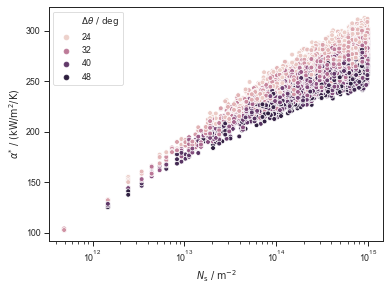

In [14]:
ax = sns.scatterplot(data=df_samples, y="alpha", x=df.columns[0], hue=df.columns[1])
plt.xscale("log")
rename_labels(ax)
plt.tight_layout()
plt.savefig("output\\sensi_fig5_sobol_scatter_1_" + scen_name + ".pdf", dpi=dpi)
plt.savefig("output\\sensi_fig5_sobol_scatter_1_" + scen_name + ".jpg", dpi=dpi)

## Scenario 4
* narrow input parameter space based on rough estimates of measurement uncertainty
* consider good coating (thin, high thermal conductivity)

In [15]:
scen_name = "s4"
df, df_samples = read_pickle(scen_name)

# prepare and filter results
df_samples = filter_samples(df_samples)
print("\nsensitivity:")
print(df)

original samples: 		 14000
samples after CAH filter: 	 14000
samples with bo > bo_crit: 	 0
minimum Bond number: 		 0.369
maximum Bond number: 		 0.857

sensitivity:
         delta_coat       N_s    k_coat       CAH     Theta   p_steam
S1         0.488679  0.338631  0.075526  0.059578  0.034529  0.024145
S1_conf    0.064746  0.081282  0.025288  0.023439  0.016775  0.013378
ST         0.498036  0.347059  0.080300  0.059726  0.033988  0.022122
ST_conf    0.049942  0.060668  0.010110  0.006319  0.003870  0.002395


### Figure 6 - Nucleation site density and coating thickness

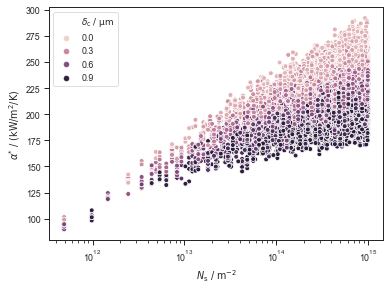

In [16]:
ax = sns.scatterplot(data=df_samples, y="alpha", x=df.columns[1], hue=df.columns[0], hue_norm=(0, 0.9))
plt.xscale("log")
rename_labels(ax)
plt.tight_layout()
plt.savefig("output\\sensi_fig6_sobol_scatter_1_" + scen_name + ".pdf", dpi=dpi)
plt.savefig("output\\sensi_fig6_sobol_scatter_1_" + scen_name + ".jpg", dpi=dpi)

contact angles, maximum coating layer thickness and minimum coating thermal conductivity for high equivalent heat transfer coefficients:

In [17]:
df_temp = df_samples[df_samples["alpha"] > 250]
print(df_temp.Theta.min())
print(df_temp.Theta.max())
print(df_temp.delta_coat.max())
print(df_temp.k_coat.min())

83.0341796875
92.9853515625
0.7016113281249999
5.02685546875
